In [1]:
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

In [2]:
dataset_url="http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url,'/root')

In [3]:
with tarfile.open('/root/cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [4]:
data_dir='/content/data/cifar10'
print(os.listdir(data_dir))
classes=os.listdir(data_dir+"/train")
print(classes)

['test', 'train', 'labels.txt']
['bird', 'deer', 'frog', 'horse', 'dog', 'airplane', 'cat', 'ship', 'automobile', 'truck']


#Data Augmentation

In [5]:
stats=((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms=tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                       tt.RandomHorizontalFlip(),
                       tt.ToTensor(),
                       tt.Normalize(*stats,inplace=True)])
valid_tfms=tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [6]:
train_ds=ImageFolder(data_dir+'/train',train_tfms)
valid_ds=ImageFolder(data_dir+'/test',valid_tfms)

In [7]:
batch_size=400

In [8]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
valid_dl=DataLoader(valid_ds,batch_size*2,num_workers=3,pin_memory=True)

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


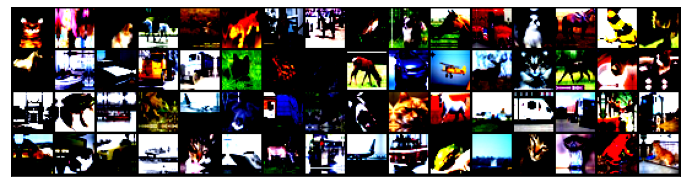

In [10]:
show_batch(train_dl)

In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device=get_default_device()
device

device(type='cuda')

In [13]:
train_dl=DeviceDataLoader(train_dl,device)
valid_dl=DeviceDataLoader(valid_dl,device)

#Residual Network with batch normalization

In [14]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu1=nn.ReLU()
    self.conv2=nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
    self.relu2=nn.ReLU()

  def forward(self,x):
    res=x
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.conv2(x)
    return self.relu2(x+res)



In [15]:
simple_resnet=to_device(SimpleResidualBlock(),device)

In [16]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    images,labels=batch
    outputs=self(images)
    loss=F.cross_entropy(outputs,labels)
    return loss
  
  def validation_step(self,batch):
    images,labels=batch
    outputs=self(images)
    loss=F.cross_entropy(outputs,labels)
    acc=accuracy(outputs,labels)
    return {'val_loss':loss.detach(),'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_losses=[x['val_loss'] for x in outputs]
    epoch_loss=torch.stack(batch_losses).mean()
    batch_acc=[x['val_acc'] for x in outputs]
    epoch_acc=torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

  


In [18]:
def conv_block(in_channels,out_channels,pool=False):
  layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
          ]
  if pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)  

class ResNet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1=conv_block(in_channels,64)
    self.conv2=conv_block(64,128,pool=True)
    self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))

    self.conv3=conv_block(128,256,pool=True)
    self.conv4=conv_block(256,512,pool=True)
    self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))

    self.classifier=nn.Sequential(nn.MaxPool2d(4),
                                  nn.Flatten(),
                                  nn.Linear(512,num_classes))
    
  def forward(self,x):
    out=self.conv1(x)
    out=self.conv2(out)
    out=self.res1(out)+out
    out=self.conv3(out)
    out=self.conv4(out)
    out=self.res2(out)+out
    out=self.classifier(out)
    return out

    



In [19]:
model=to_device(ResNet9(3,10),device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [29]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  hist=[]

  optimizer=opt_func(model.parameters(),max_lr,weight_decay=weight_decay)
  sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    model.train()
    train_losses=[]
    lrs=[]
    for batch in train_loader:
      loss=model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(),grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      lrs.append(get_lr(optimizer))
      sched.step()

    result=evaluate(model,val_loader)
    result['train_loss']=torch.stack(train_losses).mean().item()
    result['lrs']=lrs
    model.epoch_end(epoch,result)
    hist.append(result)
  return hist


In [21]:
epochs=8
max_lr=0.01
grad_clip=0.1
weight_decay=1e-4
opt_func=torch.optim.Adam

In [22]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.09586538374423981, 'val_loss': 2.3059709072113037}]

In [30]:
%%time
history+=fit_one_cycle(epochs,max_lr,model,train_dl,valid_dl,weight_decay,grad_clip,opt_func)

Epoch [0], last_lr: 0.00393, train_loss: 0.8182, val_loss: 0.9555, val_acc: 0.6812
Epoch [1], last_lr: 0.00935, train_loss: 0.8879, val_loss: 1.2923, val_acc: 0.5975
Epoch [2], last_lr: 0.00972, train_loss: 0.7776, val_loss: 0.7818, val_acc: 0.7416
Epoch [3], last_lr: 0.00812, train_loss: 0.5834, val_loss: 1.0243, val_acc: 0.6921
Epoch [4], last_lr: 0.00556, train_loss: 0.4794, val_loss: 1.0700, val_acc: 0.7322
Epoch [5], last_lr: 0.00283, train_loss: 0.3724, val_loss: 0.3706, val_acc: 0.8735
Epoch [6], last_lr: 0.00077, train_loss: 0.2679, val_loss: 0.2988, val_acc: 0.8981
Epoch [7], last_lr: 0.00000, train_loss: 0.1892, val_loss: 0.2774, val_acc: 0.9073
CPU times: user 7min 30s, sys: 6min 22s, total: 13min 53s
Wall time: 14min 47s


In [31]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

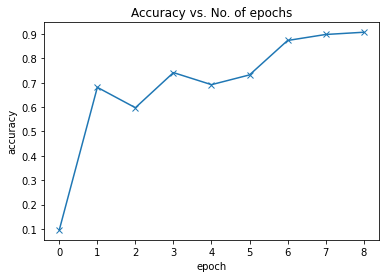

In [32]:
plot_accuracies(history)

In [33]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

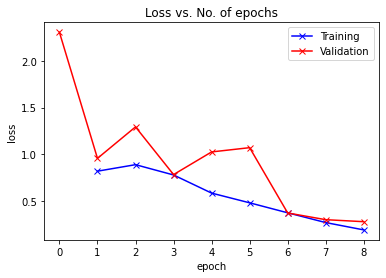

In [34]:
plot_losses(history)

In [50]:
import numpy as np

In [51]:
def plot_lr(history):
  lrs=np.concatenate([x.get('lrs',[]) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate vs Batch no.');

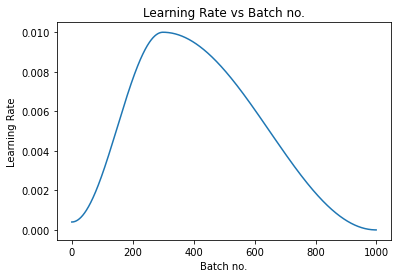

In [52]:
plot_lr(history)

In [35]:
testdataset=ImageFolder(root=data_dir+'/test',transform=ToTensor())

In [40]:
def predict_image(img,model):
  xb=to_device(img.unsqueeze(0),device)
  yb=model(xb)
  _,preds =torch.max(yb,dim=1)
  return train_ds.classes[preds[0].item()]

Label:  airplane ,Predicted:  airplane


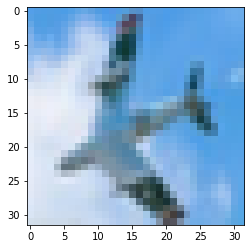

In [47]:
img,label=testdataset[100]
plt.imshow(img.permute(1,2,0))
print('Label: ', train_ds.classes[label],',Predicted: ',predict_image(img,model))

In [54]:
torch.save(model.state_dict(),'cifar10-Resnet9.pth')